# Automatic generation of masks with SAM

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import json
import pickle
from scipy.spatial.distance import directed_hausdorff
from PIL import Image

In [2]:
# specify a gpu to use
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
#    Constants
# -------------------------------------------------------------------- #

# acceptable image file extensions
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.TIF']

# SAM constants
SAM_CHECKPOINT = "/home/username/Models/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
DEVICE = "cuda"

STUDY_FOLDER = '/home/username/Code/SAM/results/' # make sure this folder exists
EXPERIMENT_DESCRIPTION = 'Running SAM custom params on the 1200 images with ground truth masks available. Calculating DICE score on the fly.'
EXPERIMENT_ID = '004'
# create this folder if it doesn't exist
os.makedirs(Path(STUDY_FOLDER, EXPERIMENT_ID), exist_ok=True)

GT_FOLDER = '/home/username/Data/Microscopy/BBBC005/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' # this will be used to synthesize the actual file names, because this folder is the ground truth folder

# Results file
OUTPUT_FILE_PATH = Path(STUDY_FOLDER, EXPERIMENT_ID, 'output.jsonl')

## Define methods here

In [4]:
# default method from SAM, modified version defined later has been used in this file
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Import images

In [4]:
# read images from the image folder (not the gt folder)
images = []
labels = []
filenames = []
for file in os.listdir(GT_FOLDER):
    # we need to replace the 'BBBC005_v1_ground_truth/BBBC005_v1_ground_truth' with 'BBBC005_v1_images' to get the actual image
    original_file_path = os.path.join(GT_FOLDER, file)
    new_file_path = original_file_path.replace('BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', 'BBBC005_v1_images')
    if any([file.endswith(ext) for ext in IMG_EXTENSIONS]):
        image = cv2.imread(new_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        # get the labels from the filename. The label is the number inside the "_C<number>_" string
        label = file.split("_")[2].strip("C")
        labels.append(label)
        filenames.append(Path(file).name)

print(f"Loaded {len(filenames)} images")

# I want to see the format and the values in the files
print(type(images[0]), images[0].shape)
print(np.min(images[0]), np.max(images[0]))

Loaded 1200 images
<class 'numpy.ndarray'> (520, 696, 3)
0 238


In [5]:
# read images from the gt folder
gt_images = []
gt_filenames = []
for file in os.listdir(GT_FOLDER):
    if any([file.endswith(ext) for ext in IMG_EXTENSIONS]):
        image = cv2.imread(os.path.join(GT_FOLDER, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gt_images.append(image)
        gt_filenames.append(Path(file).name)

print(f"Loaded {len(gt_filenames)} ground truth images")

# I want to see the format and the values in the files
print(type(gt_images[0]), gt_images[0].shape)
print(np.min(gt_images[0]), np.max(gt_images[0]))

Loaded 1200 ground truth images
<class 'numpy.ndarray'> (520, 696, 3)
0 255


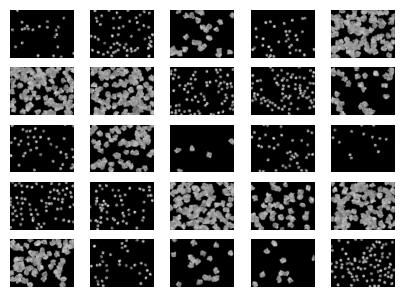

In [7]:
# plot the first 25 images in a grid
fig, axs = plt.subplots(5, 5, figsize=(5, 3.6))
for i, ax in enumerate(axs.flatten()):
    if i < 25:
        ax.imshow(images[i])
    ax.axis('off')
plt.show()

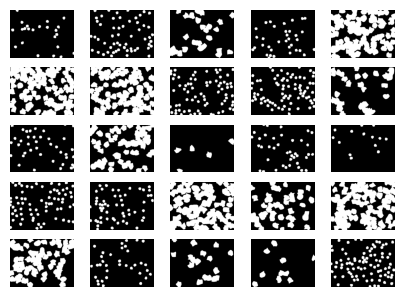

In [8]:
# plot the gt images
fig, axs = plt.subplots(5, 5, figsize=(5, 3.6))
for i, ax in enumerate(axs.flatten()):
    if i < 25:
        ax.imshow(gt_images[i])
    ax.axis('off')
plt.show()

## Initialize sam object

In [ ]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)

## Mask generation

In [7]:
# are you using default or custom generator?
USE_CUSTOM_GENERATOR = True

if USE_CUSTOM_GENERATOR:
    mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    points_per_batch = 64,
    pred_iou_thresh = 0.98, # default was 0.88 
    stability_score_thresh = 0.98, # default was 0.95
    stability_score_offset = 1.0,
    box_nms_thresh = 0.90, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks. Default 0.7
    crop_n_layers = 0,
    crop_nms_thresh = 0.95, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops. Default 0.7
    crop_overlap_ratio = 0.05, # Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap. Default 512 / 1500
    crop_n_points_downscale_factor = 1,
    point_grids = None,
    min_mask_region_area = 0, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.
    output_mode = "binary_mask"
)
else:
    mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
# modifying sam mask script to get desired images
def show_anns_binary(anns):
    # don't run if no masks are found
    if len(anns) == 0:
        return
    
    # sort the anns in the descending order of area
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # remove any mask that are at least 25% of the image area
    # calculate the area of the masks
    img_area = sorted_anns[0]['segmentation'].shape[0] * sorted_anns[0]['segmentation'].shape[1]
    sorted_anns = [ann for ann in sorted_anns if ann['area'] < 0.25 * img_area]

    # note that all masks have the same shape
    # also note that the source images have 3 channels, so I am going to create a 3 channel mask
    # create a blank image to hold the masks
    img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 3)) # binary black image

    # for each mask, set each pixel value in the blank image to 1
    for ann in sorted_anns:
        m = ann['segmentation'] # each m has the same shape as that of the image, for example (520, 696)
        img[m] = 1

    return img

In [9]:
def dice_score(img1, img2):
    return 2*np.sum(img1*img2)/(np.sum(img1) + np.sum(img2))

# let's calculate the f1 score for these two images
def f1_score(img1, img2):
    tp = np.sum(img1*img2)
    fp = np.sum(img1*(1-img2))
    fn = np.sum((1-img1)*img2)
    return tp/(tp + 0.5*(fp + fn))

# get jaccard index
def jaccard_index(img1, img2):
    tp = np.sum(img1*img2)
    fp = np.sum(img1*(1-img2))
    fn = np.sum((1-img1)*img2)
    return tp/(tp + fp + fn)

# calculate hausdorff distance
def hausdorff_distance(img1, img2):
    # both images should be 2D arrays, however our images are 3D arrays... we can average the 3 channels
    img1 = np.mean(img1, axis=2)
    img2 = np.mean(img2, axis=2)
    return max(directed_hausdorff(img1, img2)[0], directed_hausdorff(img2, img1)[0])

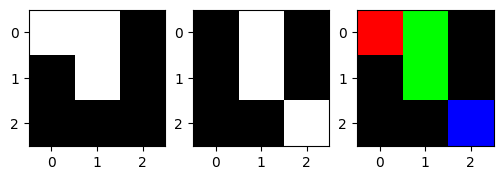

In [10]:
#    TRIAL for calculating difference between two images
# ============================================================================ #

M = np.array([[[1, 1, 1], [1, 1, 1], [0, 0, 0]],
     [[0, 0, 0], [1, 1, 1], [0, 0, 0]],
     [[0, 0, 0], [0, 0, 0], [0, 0, 0]]])
# print(M)
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.imshow(M*255)

I = np.array([[[0, 0, 0], [1, 1, 1], [0, 0, 0]],
     [[0, 0, 0], [1, 1, 1], [0, 0, 0]],
     [[0, 0, 0], [0, 0, 0], [1, 1, 1]]])
# print(I)
plt.subplot(1, 3, 2)
plt.imshow(I*255)
# plt.show()
# plt.close()

# subtract the two images to see the difference
# if the pixel is present in mask but not in gt, make it red, if it is present in gt but not in mask, make it blue, and if it is present in both, make it green
D = np.zeros((3, 3, 3))

# flatten the M and I arrays to 2D array
M = np.mean(M, axis=2)
I = np.mean(I, axis=2)
# print(M)
# print(I)

# calculate the difference
D[M == 1] = [1, 0, 0]
D[I == 1] = [0, 0, 1]
D[(M == 1) & (I == 1)] = [0, 1, 0]

plt.subplot(1, 3, 3)
plt.imshow(D)

plt.show()

plt.close()

In [ ]:
# create a images folder in the experiment folder if it doesn't exist
Path(STUDY_FOLDER, EXPERIMENT_ID, 'mask_images').mkdir(parents=True, exist_ok=True)
# create a diff_images folder in the experiment folder if it doesn't exist
Path(STUDY_FOLDER, EXPERIMENT_ID, 'diff_images').mkdir(parents=True, exist_ok=True)

# initialize a list to contain the masks
masks = []

# generate masks for each image
for img, gt_img, fname, gt_fname in zip(images, gt_images, filenames, gt_filenames):

    m = mask_generator.generate(img)
    masks.append(m)
    
    mask_img = show_anns_binary(m) 

    # save mask_img to experiment folder
    Image.fromarray((mask_img*255).astype(np.uint8)).save(Path(STUDY_FOLDER, EXPERIMENT_ID, 'mask_images', fname.split('.')[0]+'.png'))
    
    # USE THIS IF USING plt to save the image with the filename
    #  plt.savefig(Path(STUDY_FOLDER, EXPERIMENT_ID, 'images', fname.split('.')[0]+'.png'), bbox_inches='tight', pad_inches=0, format='png', dpi=140.8) # dpi is fine tuned (for a monitor with dpi 96) to match the original image size

    # print the number of masks and labels
    print('filename =', n, 'predicted count =', len(m))

    # scale the gt_img to 0-1 to match the mask_img
    gt_img = gt_img/255

    # subtract the two images to see the difference
    # if the pixel is present in mask but not in gt, make it red, if it is present in gt but not in mask, make it blue, and if it is present in both, make it green
    diff_img = np.zeros((mask_img.shape[0], mask_img.shape[1], 3))
    # flatten the mask and the image to make things easier for diff calculation
    flat_mask_img = np.mean(mask_img, axis=2)
    flat_gt_img = np.mean(gt_img, axis=2)
    # calculate the difference
    diff_img[flat_mask_img == 1] = [1, 0, 0] # red
    diff_img[flat_gt_img == 1] = [0, 0, 1] # blue
    diff_img[(flat_mask_img == 1) & (flat_gt_img == 1)] = [0, 1, 0] # green
    # save diff_img to experiment folder
    Image.fromarray((diff_img*255).astype(np.uint8)).save(Path(STUDY_FOLDER, EXPERIMENT_ID, 'diff_images', fname.split('.')[0]+'.png'))
    
    # DEBUG
    # print(mask_img.shape, gt_img.shape)
    # print(np.min(mask_img), np.max(mask_img))
    # print(np.min(gt_img), np.max(gt_img))
    # print(np.unique(mask_img), np.unique(gt_img))
        
    # calculate and print the various scores
    d_s = dice_score(mask_img, gt_img)
    f_s = f1_score(mask_img, gt_img)
    j_i = jaccard_index(mask_img, gt_img)
    h_d = hausdorff_distance(mask_img, gt_img)

    # append the results to a json file
    with open(OUTPUT_FILE_PATH, 'a') as f:
        f.write(json.dumps({
            'gt_filename': gt_fname,
            'filename': fname,
            'predicted_count': len(m),
            'dice_score': d_s,
            'f1_score': f_s,
            'jaccard_index': j_i,
            'hausdorff_distance': h_d
            }) +'\n'
        )
        
    # DEBUG
    # choose to show the mask image only if meets certain criteria of dice score
    if d_s < 0.3 or d_s > 0.9:
        print('filename =', fname, 'dice score =', d_s)
        plt.figure()
        plt.imshow(diff_img)
        plt.show()
        plt.close()

# save the masks to the experiment folder as a pickle file
masks_file = Path(STUDY_FOLDER, EXPERIMENT_ID, 'masks.pkl')
with open(masks_file, 'wb') as f:
    pickle.dump(masks, f)